# Modelo de clasificación por tipo de espacio

### Importaciones

In [1]:
import numpy as np
import os
import PIL
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

import seaborn as sn
import pandas as pd
from datetime import datetime

C:\Users\m.alvarezg1\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\m.alvarezg1\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\m.alvarezg1\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Construcción de dataset

In [20]:
#Preprocesamiento de los datos
directory="E:/TesisMA/Datos/DataCombinada"
#directory1="E:/TesisMA/Datos/DataB"
img_height=512
img_width=512
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))


Found 6774 files belonging to 5 classes.
Using 5420 files for training.
Found 6774 files belonging to 5 classes.
Using 1354 files for validation.


### Analisis del dataset

In [21]:
class_names = train_ds.class_names
print(class_names)
num_classes = 5

['bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']


[1230, 1846, 501, 1222, 621]


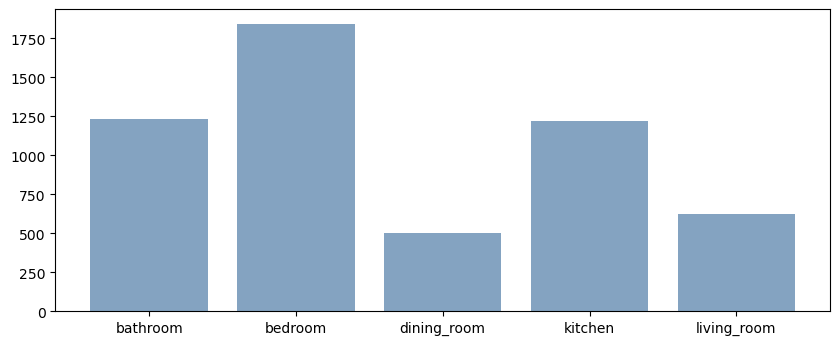

In [4]:
y = np.concatenate([y for x, y in train_ds], axis=0)
labels = list(y)
elements_per_class = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class.append(labels.count(i))
print(elements_per_class)
plt.bar(class_names,elements_per_class,color=(0.2, 0.4, 0.6, 0.6));

1354


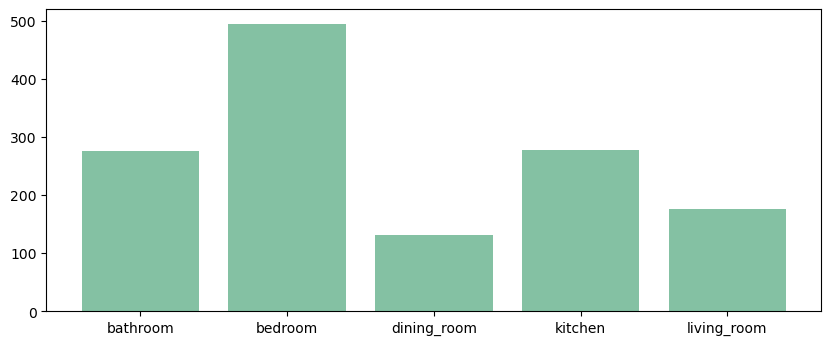

In [5]:
labels1 = np.concatenate([y for x, y in val_ds], axis=0)
labels1 = list(labels1)
elements_per_class1 = []
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
for i in range(0,num_classes):
    elements_per_class1.append(labels1.count(i))
print(sum(elements_per_class1))
plt.bar(class_names,elements_per_class1,color=(0.2, 0.6, 0.4, 0.6));

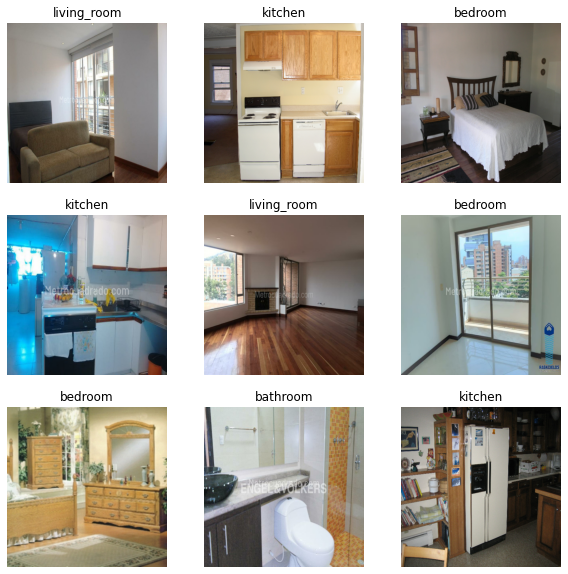

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

### CNN

In [24]:
model = Sequential([
  #Capa para realizar data augmantation
  data_augmentation,
  #Priemera capa entrada de 512x512 x3 canales de color
  layers.experimental.preprocessing.Rescaling(1/255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #    Si empiza a haber ploblemas se pone el dropout 
  layers.Flatten(),
  #layers.BatchNormalization(),
  layers.Dense(128,activation="relu", kernel_initializer="he_normal"),
  #layers.Dropout(0.1),
  layers.Dense(64,activation="relu", kernel_initializer="he_normal"),
  #layers.Dropout(0.1),
  layers.Dense(num_classes, activation='softmax')
])

### LRF Finder

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)     

In [27]:
checkpoint_filepath="E:/TesisMA/Modelos/512/Best_Modelo5_512_5_conv_droput_02x1_lr0005"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [33]:
epochs=20
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs,
callbacks=[model_checkpoint_callback]
)

Epoch 1/20
170/170 [==============================] - 917s 5s/step - loss: 0.4273 - accuracy: 0.8424 - val_loss: 0.9050 - val_accuracy: 0.7179
Epoch 2/20
170/170 [==============================] - 908s 5s/step - loss: 0.4119 - accuracy: 0.8448 - val_loss: 0.9274 - val_accuracy: 0.7275
Epoch 3/20
170/170 [==============================] - 899s 5s/step - loss: 0.4083 - accuracy: 0.8504 - val_loss: 0.8694 - val_accuracy: 0.7371
Epoch 4/20
170/170 [==============================] - 906s 5s/step - loss: 0.4086 - accuracy: 0.8577 - val_loss: 0.9355 - val_accuracy: 0.7090
Epoch 5/20
170/170 [==============================] - 667s 4s/step - loss: 0.4181 - accuracy: 0.8491 - val_loss: 0.9832 - val_accuracy: 0.7208
Epoch 6/20
170/170 [==============================] - 632s 4s/step - loss: 0.4009 - accuracy: 0.8498 - val_loss: 0.8587 - val_accuracy: 0.7334
Epoch 7/20
170/170 [==============================] - 634s 4s/step - loss: 0.4036 - accuracy: 0.8478 - val_loss: 0.9106 - val_accuracy: 0.7208

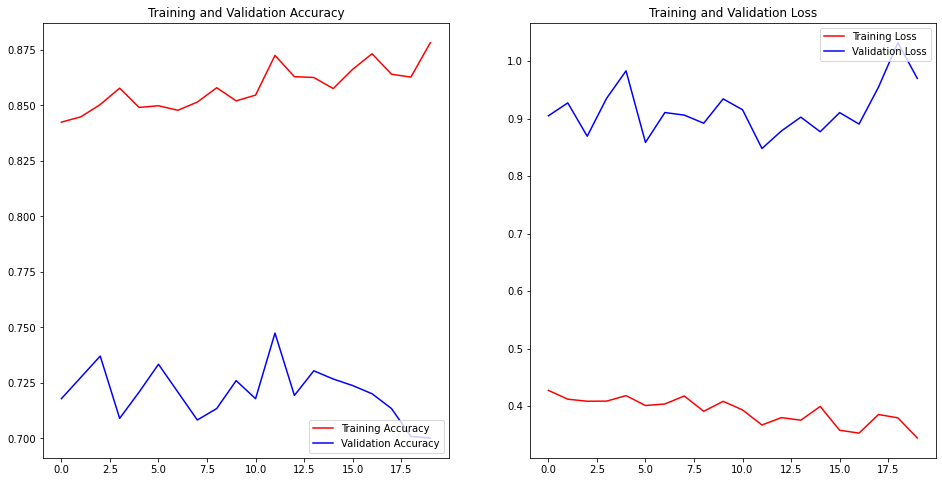

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

sn.set_palette(sn.color_palette("husl", 2))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='blue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Confusion matrix

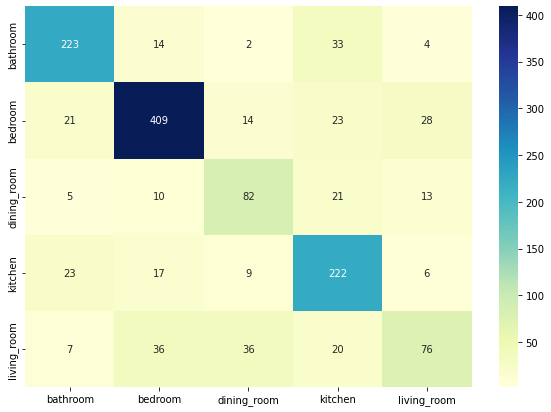

In [35]:
# Cargar mejor modelo 
model = tf.keras.models.load_model(checkpoint_filepath)

predictions = np.array([])
labels = np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])  
  labels= np.concatenate([labels, y])

matriz = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
df_cm = pd.DataFrame(matriz, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu",  fmt='g');

In [37]:
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.8, 0.84, 0.57, 0.7, 0.6]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.81, 0.83, 0.63, 0.8, 0.43]


In [36]:
report = model.evaluate(val_ds,return_dict=True)
index=["Values"]
table=pd.DataFrame(report,index=index) 
table

43/43 [==============================] - 83s 2s/step - loss: 0.8481 - accuracy: 0.7474


,loss,accuracy
Values,0.848059,0.747415


In [17]:
def metricasCM(matriz):
    # Bien clasificados sobre columna / De todas las X clasificadas solo el %  fue correcto
    metrica1= []
    # Bien clasificados sobre la fila / De todas las que deberías ser clasificadas como X solo el % fue corrcto 
    metrica2= []
    for j in range(0,5):
        suma=0
        for i in range(0,5):
            suma=suma+matriz[i][j]
        metrica1.append((matriz[j][j]/suma).round(2))
        metrica2.append((matriz[j][j]/sum(matriz[j])).round(2))
    print("De todas las X clasificadas solo el %  fue correcto",metrica1)
    print("De todas las que deberían ser clasificadas como X el % fue corrcto ",metrica2)
metricasCM(matriz)

De todas las X clasificadas solo el %  fue correcto [0.8, 0.79, 0.6, 0.76, 0.59]
De todas las que deberían ser clasificadas como X el % fue corrcto  [0.77, 0.84, 0.62, 0.75, 0.51]


#### TensorBoard

In [ ]:
root_dir = "E:/TesisMA/Modelos/my_log"
def get_run_dir():
    import time
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%D")
    return os.path.join(root_dir,run_id)

tensorboard_cb = keras.callbacks.TensorBoard(get_run_dir())


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=E:/TesisMA/Modelos/my_log --port 6006